<a href="https://colab.research.google.com/github/racoope70/daytrading-with-ml/blob/main/finished_universal_trading_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
# ✅ Universal Trading Pipeline with Google Drive Integration and Enhancements
import pandas as pd
import numpy as np
import yfinance as yf
import time, os, tensorflow as tf
import matplotlib.pyplot as plt
import zipfile
from math import ceil
from shutil import copyfile
from datetime import datetime
from google.colab import drive
import json

# ✅ Mount Google Drive and Create Save Folder
drive.mount('/content/drive')
strategy_name = 'buy_volume_macd_rsi_v1'
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
save_dir = f"/content/drive/My Drive/universal_outputs/{strategy_name}"
os.makedirs(save_dir, exist_ok=True)
print(f"Save directory is ready: {save_dir}")

# ✅ TensorFlow GPU Memory Configuration
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("TensorFlow GPU memory growth enabled")
    except RuntimeError as e:
        print(f"TensorFlow GPU memory issue: {e}")

os.environ['CUDA_HOME'] = '/usr/local/cuda-11.8'
os.environ['PATH'] += ':/usr/local/cuda-11.8/bin'
os.environ['LD_LIBRARY_PATH'] += ':/usr/local/cuda-11.8/lib64'

# ✅ Ticker List and CONFIG
ticker_list = [
    'AAPL', 'TSLA', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'BRK-B', 'JPM', 'JNJ',
    'XOM', 'V', 'PG', 'UNH', 'MA', 'HD', 'LLY', 'MRK', 'PEP', 'KO',
    'BAC', 'ABBV', 'AVGO', 'PFE', 'COST', 'CSCO', 'TMO', 'ABT', 'ACN', 'WMT',
    'MCD', 'ADBE', 'DHR', 'CRM', 'NKE', 'INTC', 'QCOM', 'NEE', 'AMD', 'TXN',
    'AMGN', 'UPS', 'LIN', 'PM', 'UNP', 'BMY', 'LOW', 'RTX', 'CVX', 'IBM',
    'GE', 'SBUX', 'ORCL'
]

CONFIG = {
    'symbols': [],
    'period': '720d',
    'interval': '1h',
    'target': 'Target',
    'sharpe_threshold': 1.5,
    'return_threshold': 1.25,
    'strategy_name': strategy_name
}

# ✅ Download Function
def download_stock_data(ticker, period="720d", interval="1h", max_retries=5):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt}: Downloading {ticker}...")
            df = yf.download(ticker, period=period, interval=interval)
            if not df.empty:
                df.reset_index(inplace=True)
                df['Symbol'] = ticker
                return df
            raise ValueError("Empty data")
        except Exception as e:
            print(f"Error: {e}. Retrying...")
            time.sleep(attempt * 5)
    print(f"Failed to download {ticker}")
    return None

# ✅ Feature Engineering
def compute_enhanced_features(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.loc[:, ~df.columns.duplicated()]

    df['SMA_20'] = df['Close'].rolling(20).mean()
    df['STD_20'] = df['Close'].rolling(20).std()
    df['Upper_Band'] = df['SMA_20'] + 2 * df['STD_20']
    df['Lower_Band'] = df['SMA_20'] - 2 * df['STD_20']
    df['Lowest_Low'] = df['Low'].rolling(14).min()
    df['Highest_High'] = df['High'].rolling(14).max()
    denom = (df['Highest_High'] - df['Lowest_Low']).replace(0, np.nan)
    df['Stoch'] = ((df['Close'] - df['Lowest_Low']) / denom) * 100
    df['ROC'] = df['Close'].pct_change(10)
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).cumsum()
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())
    df['PROC'] = ((df['Close'] - df['Close'].shift(12)) / df['Close'].shift(12)) * 100
    df['Rolling_Mean_50'] = df['Close'].rolling(50).mean()
    df['Expanding_Mean'] = df['Close'].expanding().mean()
    df['EMA_10'] = df['Close'].ewm(span=10).mean()
    df['EMA_50'] = df['Close'].ewm(span=50).mean()
    df['MACD_Line'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()
    df['MACD_Signal'] = df['MACD_Line'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(14).mean()
    loss = -delta.where(delta < 0, 0).rolling(14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['True_Range'] = df[['High', 'Low', 'Close']].apply(lambda x: max(x.iloc[0] - x.iloc[1], abs(x.iloc[0] - x.iloc[2]), abs(x.iloc[1] - x.iloc[2])), axis=1)
    df['ATR'] = df['True_Range'].rolling(14).mean()
    df['+DM'] = np.where((df['High'].diff() > df['Low'].diff()) & (df['High'].diff() > 0), df['High'].diff(), 0)
    df['-DM'] = np.where((df['Low'].diff() > df['High'].diff()) & (df['Low'].diff() > 0), df['Low'].diff(), 0)
    df['+DI'] = 100 * df['+DM'].rolling(14).mean() / df['ATR']
    df['-DI'] = 100 * df['-DM'].rolling(14).mean() / df['ATR']
    df['ADX'] = abs(df['+DI'] - df['-DI']).rolling(14).mean()
    df['Volume_Avg'] = df['Volume'].rolling(20).mean()
    df['Volume_Change'] = df['Volume'].pct_change()
    df['Volume_Change_MA'] = df['Volume_Change'].rolling(10).mean()
    df['Volume_Change_Ratio'] = df['Volume_Change'] / df['Volume_Change'].shift(1)
    df['Relative_Volume'] = df['Volume'] / df['Volume_Avg']
    df['Trailing_Stop'] = np.minimum(df['Close'] * 0.985, df['Close'] - (df['ATR'] * 0.3))
    df['Buy_Signal'] = np.where((df['RSI'] < 60) & (df['EMA_10'] > df['EMA_50']) &
                                ((df['MACD_Line'] > df['MACD_Signal']) | (df['MACD_Line'].diff() > 0)) &
                                (df['Volume'] > (0.4 * df['Volume_Avg'])) & (df['ADX'] > 18), 1, 0)
    df['Sell_Signal'] = np.where(((df['EMA_10'] < df['EMA_50']) & (df['RSI'] > 60)) |
                                 ((df['MACD_Line'] < df['MACD_Signal']) & (df['RSI'] > 65)) |
                                 (df['Close'] < df['Trailing_Stop']) |
                                 ((df['Volume'] > 0.5 * df['Volume_Avg']) & (df['ADX'] > 20)), 1, 0)
    df['Sell_Signal_Debug'] = np.where(((df['MACD_Hist'] < 0.5) | (df['MACD_Line'] < df['MACD_Signal'])) &
                                       (df['RSI'] < 55) & (df['ADX'] > 15) &
                                       ((df['Close'] < df['Trailing_Stop']) | (df['EMA_10'] < df['EMA_50'])) &
                                       (df['Volume'] > 0.5 * df['Volume_Avg']), 1, 0)
    df['Future_Close'] = df['Close'].shift(-10)
    df['Volatility'] = df['Close'].pct_change().rolling(window=20).std()

    df['Return'] = (df['Future_Close'] - df['Close']) / df['Close']
    df['Target'] = np.select([df['Return'] > 0.02, df['Return'] < -0.02], [1, -1], default=0)
    df['Multi_Class_Target'] = df['Target']
    df['Hour'] = pd.to_datetime(df['Datetime']).dt.hour
    df['DayOfWeek'] = pd.to_datetime(df['Datetime']).dt.dayofweek
    df['Session'] = np.where((df['Hour'] >= 9) & (df['Hour'] <= 16), 'Regular',
                             np.where((df['Hour'] < 9), 'Pre-market', 'After-hours'))
    df['MACD_Crossover'] = np.where(df['MACD_Line'] > df['MACD_Signal'], 1, 0)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    df.dropna(inplace=True)
    return df

# ✅ Backtest & Metrics
def simple_backtest(df, target_col='Target', initial_cash=10000, position_size=1.0):
    df = df.copy()
    df['Return'] = df['Close'].pct_change()
    df['Strategy_Return'] = df[target_col].shift(1) * df['Return'] * position_size
    df['Equity_Curve'] = initial_cash * (1 + df['Strategy_Return']).cumprod()
    return df

def evaluate_performance_metrics(df):
    df = df.copy()
    df['Datetime'] = pd.to_datetime(df['Datetime'])
    df.set_index('Datetime', inplace=True)
    daily_returns = df['Equity_Curve'].pct_change().dropna()
    excess_returns = daily_returns
    sharpe = np.sqrt(252) * excess_returns.mean() / excess_returns.std()
    trades = df['Strategy_Return'][df['Strategy_Return'] != 0]
    win_loss = trades[trades > 0].count() / trades[trades < 0].count() if trades[trades < 0].count() > 0 else np.inf
    drawdown = (df['Equity_Curve'] - df['Equity_Curve'].cummax()) / df['Equity_Curve'].cummax()
    cagr = (df['Equity_Curve'].iloc[-1] / df['Equity_Curve'].iloc[0]) ** (1 / ((df.index[-1] - df.index[0]).days / 365.25)) - 1
    df.reset_index(inplace=True)
    return {'Sharpe Ratio': sharpe, 'Win/Loss Ratio': win_loss, 'Max Drawdown': drawdown.min(), 'CAGR': cagr}

# ✅ Run Pipeline
def run_universal_framework(config):
    all_results, all_metrics, filtered = {}, {}, []
    for symbol in config['symbols']:
        print(f"Processing {symbol}")
        df = download_stock_data(symbol, config['period'], config['interval'])
        if df is None: continue
        df = compute_enhanced_features(df)
        df = simple_backtest(df, config['target'])
        metrics = evaluate_performance_metrics(df)
        final_return = df['Equity_Curve'].iloc[-1]
        sharpe = metrics.get('Sharpe Ratio', 0)
        print(f"🔎 {symbol} Sharpe: {sharpe:.2f}, Final Return: {final_return:.2f}")
        if sharpe > config['sharpe_threshold'] or final_return > config['return_threshold']:
            all_results[symbol], all_metrics[symbol] = df, metrics
            filtered.append(symbol)
            df.to_csv(f"/content/{config['strategy_name']}_{symbol}_features.csv", index=False)
            pd.DataFrame.from_dict(metrics, orient='index', columns=['Value']).to_csv(f"/content/{config['strategy_name']}_{symbol}_metrics.csv")
    return all_results, all_metrics, filtered

# ✅ Chunk Execution
chunk_size = 10
combined_df = pd.DataFrame()
global_results, global_metrics, global_filtered = {}, {}, []

for i in range(0, len(ticker_list), chunk_size):
    CONFIG['symbols'] = ticker_list[i:i+chunk_size]
    print(f"Running chunk {i // chunk_size + 1}...")
    results, metrics, filtered = run_universal_framework(CONFIG)
    global_results.update(results)
    global_metrics.update(metrics)
    global_filtered.extend(filtered)

    for ticker in filtered:
        df = results[ticker]
        final_columns = [
            'Datetime', 'Open', 'High', 'Low', 'Close', 'Volume',
            'EMA_10', 'EMA_50', 'SMA_20', 'Rolling_Mean_50', 'Expanding_Mean',
            'RSI', 'MACD_Line', 'MACD_Signal', 'MACD_Hist',
            'ATR', 'Volatility', 'Volume_Avg', 'Volume_Change', 'Volume_Change_MA',
            'Volume_Change_Ratio', 'Relative_Volume', 'ADX', 'Trailing_Stop',
            'Buy_Signal', 'Sell_Signal', 'Sell_Signal_Debug',
            'Return', 'Target', 'Multi_Class_Target', 'Hour', 'DayOfWeek', 'Session',
            'MACD_Crossover', 'Future_Close']
        df.replace([np.inf, -np.inf], np.nan, inplace=True)
        df.dropna(inplace=True)
        df_labeled = df[final_columns]
        combined_df = pd.concat([combined_df, df_labeled], axis=0)
        path = f"{save_dir}/{CONFIG['strategy_name']}_{ticker}_labeled_dataset.csv"
        df_labeled.to_csv(path, index=False)
        print(f"Saved: {path}")

# ✅ Save Combined Dataset
combined_path = f"{save_dir}/combined_dataset_{timestamp}.csv"
combined_df.to_csv(combined_path, index=False)
print(f"Combined dataset saved: {combined_path}")

# ✅ Zip and Upload
with zipfile.ZipFile("/content/universal_strategy_outputs.zip", "w") as zipf:
    for ticker in global_filtered:
        zipf.write(f"/content/{CONFIG['strategy_name']}_{ticker}_features.csv")
        zipf.write(f"/content/{CONFIG['strategy_name']}_{ticker}_metrics.csv")
copyfile("/content/universal_strategy_outputs.zip", f"{save_dir}/universal_strategy_outputs.zip")
print("Zipped results uploaded to Google Drive")

# ✅ Log Filtered Tickers
pd.Series(global_filtered).to_csv(f"{save_dir}/filtered_tickers.csv", index=False)
print(f"Filtered tickers saved to: {save_dir}/filtered_tickers.csv")

# ✅ Strategy Summary Log (Enhanced with Filtered Ticker List)
summary_path = f"{save_dir}/summary_{timestamp}.txt"
with open(summary_path, "w") as f:
    f.write(f"Strategy: {strategy_name}\n")
    f.write(f"Total tickers evaluated: {len(ticker_list)}\n")
    f.write(f"Tickers passing filter: {len(global_filtered)}\n")
    f.write(f"Saved at: {timestamp}\n")
    f.write("Filtered Tickers:\n")
    f.write(", ".join(global_filtered) + "\n")

print(f" Summary log created at: {summary_path}")


# ✅ Save CONFIG as JSON
with open(f"{save_dir}/config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)
print(f"CONFIG saved to: {save_dir}/config.json")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Save directory is ready: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1
Running chunk 1...
Processing AAPL
Attempt 1: Downloading AAPL...


[*********************100%***********************]  1 of 1 completed


🔎 AAPL Sharpe: 2.92, Final Return: 643819.01
Processing TSLA
Attempt 1: Downloading TSLA...


[*********************100%***********************]  1 of 1 completed


🔎 TSLA Sharpe: 3.88, Final Return: 12975461478.62
Processing MSFT
Attempt 1: Downloading MSFT...


[*********************100%***********************]  1 of 1 completed


🔎 MSFT Sharpe: 2.91, Final Return: 566080.71
Processing GOOGL
Attempt 1: Downloading GOOGL...


[*********************100%***********************]  1 of 1 completed


🔎 GOOGL Sharpe: 3.02, Final Return: 2767891.79
Processing AMZN
Attempt 1: Downloading AMZN...


[*********************100%***********************]  1 of 1 completed


🔎 AMZN Sharpe: 3.22, Final Return: 9475636.69
Processing NVDA
Attempt 1: Downloading NVDA...


[*********************100%***********************]  1 of 1 completed


🔎 NVDA Sharpe: 3.69, Final Return: 1455431933.85
Processing META
Attempt 1: Downloading META...


[*********************100%***********************]  1 of 1 completed


🔎 META Sharpe: 2.96, Final Return: 32858661.60
Processing BRK-B
Attempt 1: Downloading BRK-B...


[*********************100%***********************]  1 of 1 completed


🔎 BRK-B Sharpe: 2.23, Final Return: 49600.69
Processing JPM
Attempt 1: Downloading JPM...


[*********************100%***********************]  1 of 1 completed


🔎 JPM Sharpe: 2.62, Final Return: 270121.83
Processing JNJ
Attempt 1: Downloading JNJ...


[*********************100%***********************]  1 of 1 completed


🔎 JNJ Sharpe: 1.93, Final Return: 38442.95
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_AAPL_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_TSLA_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_MSFT_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_GOOGL_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_AMZN_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_NVDA_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_META_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_BRK-B_labeled_dataset

[*********************100%***********************]  1 of 1 completed


🔎 XOM Sharpe: 3.20, Final Return: 835762.05
Processing V
Attempt 1: Downloading V...


[*********************100%***********************]  1 of 1 completed


🔎 V Sharpe: 2.32, Final Return: 86007.01
Processing PG
Attempt 1: Downloading PG...


[*********************100%***********************]  1 of 1 completed


🔎 PG Sharpe: 1.96, Final Return: 43336.72
Processing UNH
Attempt 1: Downloading UNH...


[*********************100%***********************]  1 of 1 completed


🔎 UNH Sharpe: 2.59, Final Return: 413618.49
Processing MA
Attempt 1: Downloading MA...


[*********************100%***********************]  1 of 1 completed


🔎 MA Sharpe: 2.37, Final Return: 109093.24
Processing HD
Attempt 1: Downloading HD...


[*********************100%***********************]  1 of 1 completed


🔎 HD Sharpe: 2.73, Final Return: 233874.29
Processing LLY
Attempt 1: Downloading LLY...


[*********************100%***********************]  1 of 1 completed


🔎 LLY Sharpe: 2.89, Final Return: 1801437.26
Processing MRK
Attempt 1: Downloading MRK...


[*********************100%***********************]  1 of 1 completed


🔎 MRK Sharpe: 2.35, Final Return: 125224.59
Processing PEP
Attempt 1: Downloading PEP...


[*********************100%***********************]  1 of 1 completed


🔎 PEP Sharpe: 2.12, Final Return: 42049.56
Processing KO
Attempt 1: Downloading KO...


[*********************100%***********************]  1 of 1 completed


🔎 KO Sharpe: 1.78, Final Return: 24939.71
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_XOM_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_V_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_PG_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_UNH_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_MA_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_HD_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_LLY_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_MRK_labeled_dataset.csv
Saved: /con

[*********************100%***********************]  1 of 1 completed


🔎 BAC Sharpe: 3.11, Final Return: 1037787.51
Processing ABBV
Attempt 1: Downloading ABBV...


[*********************100%***********************]  1 of 1 completed


🔎 ABBV Sharpe: 2.25, Final Return: 167379.52
Processing AVGO
Attempt 1: Downloading AVGO...


[*********************100%***********************]  1 of 1 completed


🔎 AVGO Sharpe: 3.45, Final Return: 48722620.59
Processing PFE
Attempt 1: Downloading PFE...


[*********************100%***********************]  1 of 1 completed


🔎 PFE Sharpe: 3.04, Final Return: 402452.36
Processing COST
Attempt 1: Downloading COST...


[*********************100%***********************]  1 of 1 completed


🔎 COST Sharpe: 2.60, Final Return: 168253.00
Processing CSCO
Attempt 1: Downloading CSCO...


[*********************100%***********************]  1 of 1 completed


🔎 CSCO Sharpe: 2.10, Final Return: 113527.71
Processing TMO
Attempt 1: Downloading TMO...


[*********************100%***********************]  1 of 1 completed


🔎 TMO Sharpe: 2.88, Final Return: 430794.49
Processing ABT
Attempt 1: Downloading ABT...


[*********************100%***********************]  1 of 1 completed


🔎 ABT Sharpe: 2.40, Final Return: 119587.36
Processing ACN
Attempt 1: Downloading ACN...


[*********************100%***********************]  1 of 1 completed


🔎 ACN Sharpe: 2.83, Final Return: 496005.97
Processing WMT
Attempt 1: Downloading WMT...


[*********************100%***********************]  1 of 1 completed


🔎 WMT Sharpe: 1.87, Final Return: 72465.40
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_BAC_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_ABBV_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_AVGO_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_PFE_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_COST_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_CSCO_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_TMO_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_ABT_labeled_dataset.csv
S

[*********************100%***********************]  1 of 1 completed


🔎 MCD Sharpe: 2.02, Final Return: 40610.30
Processing ADBE
Attempt 1: Downloading ADBE...


[*********************100%***********************]  1 of 1 completed


🔎 ADBE Sharpe: 3.12, Final Return: 8209700.47
Processing DHR
Attempt 1: Downloading DHR...


[*********************100%***********************]  1 of 1 completed


🔎 DHR Sharpe: 2.94, Final Return: 657762.40
Processing CRM
Attempt 1: Downloading CRM...


[*********************100%***********************]  1 of 1 completed


🔎 CRM Sharpe: 3.11, Final Return: 8871952.49
Processing NKE
Attempt 1: Downloading NKE...


[*********************100%***********************]  1 of 1 completed


🔎 NKE Sharpe: 2.62, Final Return: 2111269.52
Processing INTC
Attempt 1: Downloading INTC...


[*********************100%***********************]  1 of 1 completed


🔎 INTC Sharpe: 3.15, Final Return: 145145618.79
Processing QCOM
Attempt 1: Downloading QCOM...


[*********************100%***********************]  1 of 1 completed


🔎 QCOM Sharpe: 3.54, Final Return: 14353702.39
Processing NEE
Attempt 1: Downloading NEE...


[*********************100%***********************]  1 of 1 completed


🔎 NEE Sharpe: 2.96, Final Return: 784481.31
Processing AMD
Attempt 1: Downloading AMD...


[*********************100%***********************]  1 of 1 completed


🔎 AMD Sharpe: 3.91, Final Return: 998864958.98
Processing TXN
Attempt 1: Downloading TXN...


[*********************100%***********************]  1 of 1 completed


🔎 TXN Sharpe: 3.22, Final Return: 958509.66
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_MCD_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_ADBE_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_DHR_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_CRM_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_NKE_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_INTC_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_QCOM_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_NEE_labeled_dataset.csv
S

[*********************100%***********************]  1 of 1 completed


🔎 AMGN Sharpe: 2.33, Final Return: 223089.71
Processing UPS
Attempt 1: Downloading UPS...


[*********************100%***********************]  1 of 1 completed


🔎 UPS Sharpe: 2.49, Final Return: 490020.42
Processing LIN
Attempt 1: Downloading LIN...


[*********************100%***********************]  1 of 1 completed


🔎 LIN Sharpe: 2.17, Final Return: 83261.41
Processing PM
Attempt 1: Downloading PM...


[*********************100%***********************]  1 of 1 completed


🔎 PM Sharpe: 2.20, Final Return: 85909.00
Processing UNP
Attempt 1: Downloading UNP...


[*********************100%***********************]  1 of 1 completed


🔎 UNP Sharpe: 2.49, Final Return: 214011.33
Processing BMY
Attempt 1: Downloading BMY...


[*********************100%***********************]  1 of 1 completed


🔎 BMY Sharpe: 2.62, Final Return: 292975.20
Processing LOW
Attempt 1: Downloading LOW...


[*********************100%***********************]  1 of 1 completed


🔎 LOW Sharpe: 2.91, Final Return: 524744.79
Processing RTX
Attempt 1: Downloading RTX...


[*********************100%***********************]  1 of 1 completed


🔎 RTX Sharpe: 2.11, Final Return: 149954.36
Processing CVX
Attempt 1: Downloading CVX...


[*********************100%***********************]  1 of 1 completed


🔎 CVX Sharpe: 2.89, Final Return: 427002.78
Processing IBM
Attempt 1: Downloading IBM...


[*********************100%***********************]  1 of 1 completed


🔎 IBM Sharpe: 2.14, Final Return: 155647.07
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_AMGN_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_UPS_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_LIN_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_PM_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_UNP_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_BMY_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_LOW_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_RTX_labeled_dataset.csv
Save

[*********************100%***********************]  1 of 1 completed


🔎 GE Sharpe: 3.21, Final Return: 1957206.00
Processing SBUX
Attempt 1: Downloading SBUX...


[*********************100%***********************]  1 of 1 completed


🔎 SBUX Sharpe: 2.11, Final Return: 471156.52
Processing ORCL
Attempt 1: Downloading ORCL...


[*********************100%***********************]  1 of 1 completed


🔎 ORCL Sharpe: 2.72, Final Return: 1985374.59
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_GE_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_SBUX_labeled_dataset.csv
Saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/buy_volume_macd_rsi_v1_ORCL_labeled_dataset.csv
Combined dataset saved: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/combined_dataset_20250405_0139.csv
Zipped results uploaded to Google Drive
Filtered tickers saved to: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/filtered_tickers.csv
 Summary log created at: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/summary_20250405_0139.txt
CONFIG saved to: /content/drive/My Drive/universal_outputs/buy_volume_macd_rsi_v1/config.json


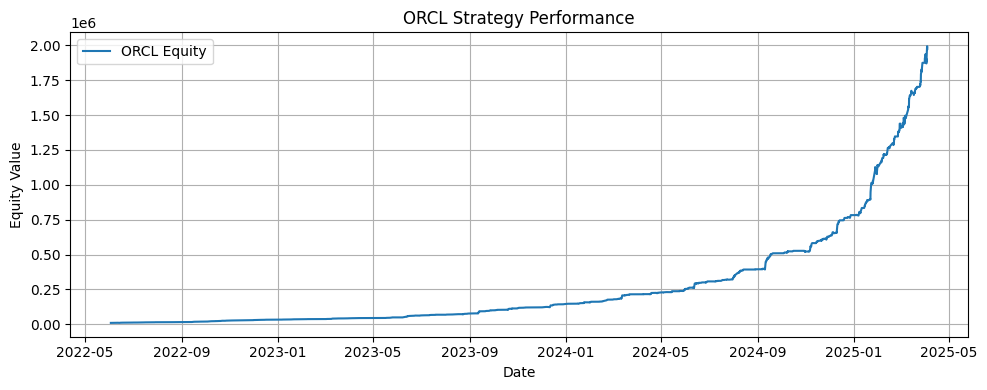

In [71]:
plt.figure(figsize=(10, 4))
plt.plot(df['Datetime'], df['Equity_Curve'], label=f"{ticker} Equity")
plt.title(f"{ticker} Strategy Performance")
plt.xlabel("Date")
plt.ylabel("Equity Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
